## 10/03/2025
### Did a bunch of stuff:

1. Baseline with RF/Logistic regression
    1. RF does not seem to predict almost any positive with default threshold, however it has higher ranking scores.
    2. LRs need imputation for nan's + scaling and they tend to over-predict by a lot. Ranking-wise not good
    3. **Best RF R@Precision: 10.97%** but abysmall F1
2. Worked on **Features** a bit
    1. Obviously some are more informative than others. Important to note that this changes a bit over time as well.
    2. Using catboost (see below), CIK greatly helps results (SIC a bit less, State much less).
3. Worked on **CatBoost**:
    1. With no weights, balanced, manual_scaling, logloss, cross-entropy, focal_loss with different alpha/gamma.
    2. Best one seemed to be **with manual x2 positive scaling weight**.
4. Tasks seems much easier the **first years**!
    1. Something happens along the way (obv. some years we have fewer data), but the drop is disproportional.
    2. Also **CIK greatly helps early on but falls off later**. Need to check the data for serial misstatements or something similar?
5. Tried out **incremental learning** with CatBoost.
    1. E.g. After fitting on the first folder data, when we move on the next folder we initialize the model with the previous one.
    2. Tried with both default train samples and dropping what is already seen.
    3. It does not work any better




### Best performance CatBoost with R@Precision: 24.17%, F1 (positive): 0.18 averaged across all splits


Todos:
- Create utils.
- Port to scripts.

In [474]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [478]:

import os
import tqdm
import time
import numpy as np
import pandas as pd


from sklearn.metrics import precision_recall_fscore_support, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

# from sklearn.linear_model import LogisticRegression
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier




def r_at_k(y_true:np.ndarray, y_probas:np.ndarray, k='precision')->float:
    """Return recall at K"""
    
    # this is recall at precision level, aka number of positives
    if k == 'precision':
        num_to_check = y_true.sum()
    else:
        # if not, check if it is int to report r@k
        if isinstance(k, int):
            num_to_check = k
        # else it is interpreted as r@k% of the test cases
        elif isinstance(k, float):
            num_to_check = int(k*len(y_test))
    k = min(num_to_check, len(y_test))
            
    sorted_indices = np.argsort(y_probas)[::-1]
    found_labels = y_true[sorted_indices]
    return found_labels[:num_to_check].sum() / num_to_check


random_state = 42

path_to_files = "../data/"
folder_files = [f'split_{year_int}' for year_int in range(2003, 2015)]

target_col = "Misstatement"
columns_to_drop = [
    #'CIK', 
    'Company',
    'Type', 
    'Date', 
    'Period of Report',
    'Fiscal Year End',
    "Basename", 
    "gvkey", 
    "restatement_year",
    "Misstatement_AA",
    "Misstatement", 
    "Misstatement_BAO"
    ]
not_sure_what = [
    'sich', 
    'insbnk', 
    'understatement', 
    'option'
    ]
not_leak = [
    'State', 
    # 'State of Inc', 
    # 'SIC'
    ]

to_remove = columns_to_drop + not_sure_what + not_leak



results = []
cm = np.zeros((2,2))
importances = []
clf = None

for folder in tqdm.tqdm_notebook(folder_files):
    
    # LOAD DATA
    df_train = pd.read_csv(os.path.join(path_to_files, folder, "train_instances.csv"))
    df_train[['CIK', 'SIC']] = df_train[['CIK', 'SIC']].astype(int)
    
    
    df_test = pd.read_csv(os.path.join(path_to_files, folder, "test_instances.csv"))
    df_test[['CIK', 'SIC']] = df_test[['CIK', 'SIC']].astype(int)
    
    to_keep = df_train.columns[~df_train.columns.isin(to_remove)].tolist()


    train = df_train[to_keep + [target_col]].dropna()
    X_train = train[to_keep].values
    y_train = train[target_col].values.astype(int)
    
    test = df_test[to_keep + [target_col]].dropna()
    X_test = test[to_keep].values
    y_test = test[target_col].values.astype(int)
    
    
    # FIT + PREDICT
    
    time_s = time.time()
    
    # clf = RandomForestClassifier(random_state=random_state)
    
    # clf = Pipeline([
    #     ('imp', SimpleImputer(strategy='mean')),
    #     ('sc', StandardScaler()),
    #     #('clf', FeatRadius(cumsum_threshold=0.4))
    #     ('clf', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))
    # ])

    #clf.fit(X_train, y_train)
    
    
    
    #loss = "Focal:focal_alpha=0.25;focal_gamma=2"
    
    # use this for early stopping
    cur_X_train, cur_X_val, cur_y_train, cur_y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)
    
    clf = CatBoostClassifier(
        iterations=1000,
        # these are CIK, SIC, State of Inc
        cat_features=[0,1,2],
        #loss_function=loss,
        
        early_stopping_rounds=100,
        verbose=1,
        task_type="CPU",
        devices="1",
        #boosting_type="Plain",
        #auto_class_weights="Balanced",
        scale_pos_weight=2
        # thread_count=-1,
        random_seed=random_state,
        )
    
    clf.fit(cur_X_train, cur_y_train, eval_set=(cur_X_val, cur_y_val), verbose=0)
    

    # For incremental learning
    
    # if clf is None:
    #     clf = CatBoostClassifier(
    #     iterations=1000,
    #     cat_features=[0,1,2],
    #     #loss_function=loss,
    #     random_seed=random_state,
    #     early_stopping_rounds=100,
    #     verbose=1,
    #     task_type="CPU",
    #     devices="1",
    #     #boosting_type="Plain",
    #     #auto_class_weights="Balanced",
    #     #scale_pos_weight=2
    #     # thread_count=-1,
    #     )
    #     clf.fit(cur_X_train, cur_y_train, eval_set=(cur_X_val, cur_y_val), verbose=0)
    # else:
    #     clf.fit(cur_X_train, cur_y_train, eval_set=(cur_X_val, cur_y_val), verbose=0, init_model=clf)
    
    # print(f'Year: {int(folder.split("_")[1])} important feats:')
    # for feat_index in np.argsort(clf.feature_importances_)[::-1][:5]:
        
    #     print(f"{to_keep[feat_index]} : {clf.feature_importances_[feat_index]:.3f}")
    # print()
    
    importances.append(clf.feature_importances_)
    y_test_proba = clf.predict_proba(X_test)[:, 1]
    
    time_e = time.time() - time_s
    
    
    # METRICS
    
    y_test_pred = (y_test_proba > 0.5).astype(int)
    cm += confusion_matrix(y_test, y_test_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary', zero_division=0)
    ap = average_precision_score(y_test, y_test_proba)
    auroc = roc_auc_score(y_test, y_test_proba)
    
    metrics = {'prec_pos':prec, 'rec_pos':rec, 'f1_pos':f1, 'ap':ap, 'auroc':auroc}
    for k in [100, 'precision']:
        metrics[f"rec@{k}"] = r_at_k(y_test, y_test_proba, k=k)
    
    cur_res = {
        "split": int(folder.split('_')[1]),
        "num_train":y_train.shape[0],
        "num_pos_train": y_train.sum(),
        "num_test":y_test.shape[0],
        "num_pos_test": y_test.sum(),
        "time": time_e,
    }
    cur_res.update(metrics)
    results.append(cur_res) 
    #print(cur_res)
    #break
    
print(f'Total Confusion Matrix')
print(cm)

df_res = pd.DataFrame(results, columns=cur_res.keys())
df_res.sort_values('split', inplace=True)
df_res


/tmp/ipykernel_1146831/3563091796.py:73: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for folder in tqdm.tqdm_notebook(folder_files):


  0%|          | 0/12 [00:00<?, ?it/s]

[[31478.    61.]
 [  745.   113.]]


,split,num_train,num_pos_train,num_test,num_pos_test,time,prec_pos,rec_pos,f1_pos,ap,auroc,rec@100,rec@precision
0,2003,7890,175,3001,87,1.678423,0.771429,0.310345,0.442623,0.404781,0.743632,0.39,0.448276
1,2004,8468,214,2941,80,2.059283,0.666667,0.350000,0.459016,0.369163,0.733930,0.35,0.412500
2,2005,9110,228,2834,80,1.767919,0.641026,0.312500,0.420168,0.303148,0.747059,0.31,0.375000
3,2006,8776,191,2788,56,1.323280,0.500000,0.232143,0.317073,0.140584,0.685918,0.15,0.267857
4,2007,8563,174,2721,50,1.536643,0.400000,0.120000,0.184615,0.170950,0.686290,0.16,0.280000
5,2008,8343,144,2718,57,1.370555,1.000000,0.087719,0.161290,0.176981,0.591012,0.14,0.228070
6,2009,8227,114,2694,59,1.141748,0.666667,0.033898,0.064516,0.140620,0.579429,0.15,0.203390
7,2010,8133,112,2667,71,1.451256,1.000000,0.042254,0.081081,0.148363,0.628253,0.13,0.169014
8,2011,8079,121,2571,65,1.980019,0.800000,0.061538,0.114286,0.128137,0.564786,0.13,0.184615
9,2012,7932,117,2513,80,1.097876,0.000000,0.000000,0.000000,0.088208,0.640485,0.10,0.125000


<!-- split            2008.500000
num_train        9142.583333
num_pos_train     166.750000
num_test         3034.666667
num_pos_test       78.833333
time                4.083638
prec_pos            0.083333
rec_pos             0.001016
f1_pos              0.002008
ap                  0.074134
auroc               0.613035
rec@100             0.097500
rec@precision       0.109147 -->

In [475]:
df_res.mean(axis=0)

split            2008.500000
num_train        8236.416667
num_pos_train     154.416667
num_test         2699.750000
num_pos_test       71.500000
time                1.550409
prec_pos            0.537149
rec_pos             0.129200
f1_pos              0.187056
ap                  0.184320
auroc               0.652802
rec@100             0.182500
rec@precision       0.241768
dtype: float64

In [476]:


# Catboost no focal with auto_pos_scale 2 seems better?
# prec_pos            0.537149
# rec_pos             0.129200
# f1_pos              0.187056
# ap                  0.184320
# auroc               0.652802
# rec@100             0.182500
# rec@precision       0.241768

# Catboost no focal with auto_pos_scale 10 is worse

# Catboost no focal with balanced is "worse", better precision worse recall
# Catboost with focal 0.25,2 is worse
# Catboost with incremental learning seems worse (both by dropping and not)


## EFFECT OF REMOVING CIK from best effort
# prec_pos            0.166667
# rec_pos             0.002625
# f1_pos              0.005162
# ap                  0.078251
# auroc               0.604202
# rec@100             0.077500
# rec@precision       0.095299



In [451]:
feat_imps = np.vstack((importances))
feat_imps = feat_imps[df_res.index.values]
feat_imps[0]

array([7.18256665, 2.48686468, 1.43482469, 2.50237368, 1.26325607,
       1.24711923, 2.86179927, 1.47960223, 2.76576541, 2.78150831,
       1.4323994 , 1.92917133, 1.24505637, 1.29611176, 1.64326181,
       1.4872689 , 2.91589538, 0.76417231, 1.21374529, 1.81595157,
       1.52713817, 2.53912053, 1.20406798, 0.52887106, 1.84965278,
       1.37739303, 3.06640703, 1.40834767, 0.92065444, 1.45420638,
       4.33482076, 2.08263169, 2.86829657, 2.8536239 , 0.7356265 ,
       5.66688119, 3.21840722, 1.74531761, 2.98853524, 0.43002433,
       3.35185064, 2.13809096, 2.90781592, 3.44527401, 3.60823005])

In [452]:
for feat_index in np.argsort(feat_imps.mean(axis=0))[::-1]:
    print(f"({feat_index}) {to_keep[feat_index]} : {feat_imps.mean(axis=0)[feat_index]:.3f}")

(0) CIK : 5.841
(35) soft_assets : 3.433
(40) bm : 3.191
(9) csho : 3.041
(43) EBIT : 3.036
(1) SIC : 2.826
(16) ivao : 2.780
(32) ch_rsst : 2.728
(36) ch_cs : 2.672
(33) dch_rec : 2.658
(26) sstk : 2.652
(44) ch_fcf : 2.626
(42) reoa : 2.573
(10) dlc : 2.534
(6) ceq : 2.497
(31) dch_wc : 2.438
(41) dpi : 2.391
(30) prcc_f : 2.365
(38) ch_roa : 2.294
(37) ch_cm : 2.280
(2) State of Inc : 2.264
(28) txt : 2.206
(23) re : 1.988
(7) che : 1.982
(29) xint : 1.920
(34) dch_inv : 1.902
(17) ivst : 1.873
(24) rect : 1.865
(13) dp : 1.840
(15) invt : 1.809
(4) ap : 1.796
(14) ib : 1.790
(21) ppegt : 1.772
(20) ni : 1.765
(3) act : 1.714
(8) cogs : 1.655
(18) lct : 1.628
(25) sale : 1.613
(5) at : 1.588
(27) txp : 1.567
(11) dltis : 1.544
(12) dltt : 1.507
(19) lt : 1.415
(39) issue : 1.204
(22) pstk : 0.939


Text(0, 0.5, 'f1_pos')

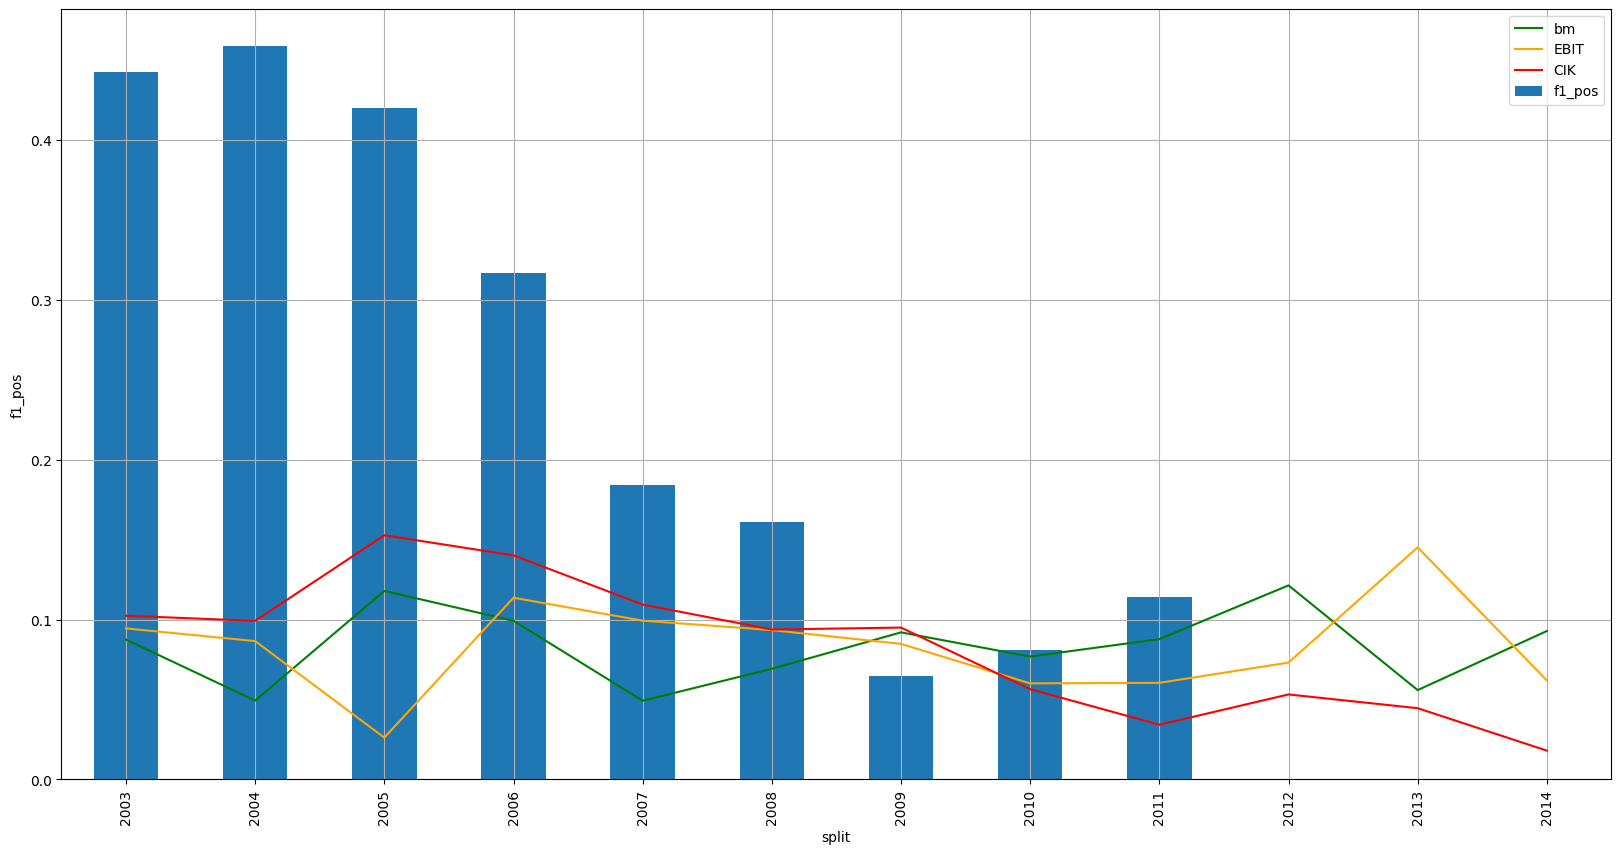

In [453]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
metric = 'f1_pos'

df_res.set_index('split')[f'{metric}'].plot(kind='bar', grid="on")

feat_index = 40
plt.plot(feat_imps[:,feat_index]/feat_imps[:,feat_index].sum(), color='g', label=to_keep[feat_index])

feat_index = 43
plt.plot(feat_imps[:,feat_index]/feat_imps[:,feat_index].sum(), color='orange', label=to_keep[feat_index])

feat_index = 0
plt.plot(feat_imps[:,feat_index]/feat_imps[:,feat_index].sum(), color='r', label=to_keep[feat_index])



plt.legend()

plt.ylabel(f'{metric}')

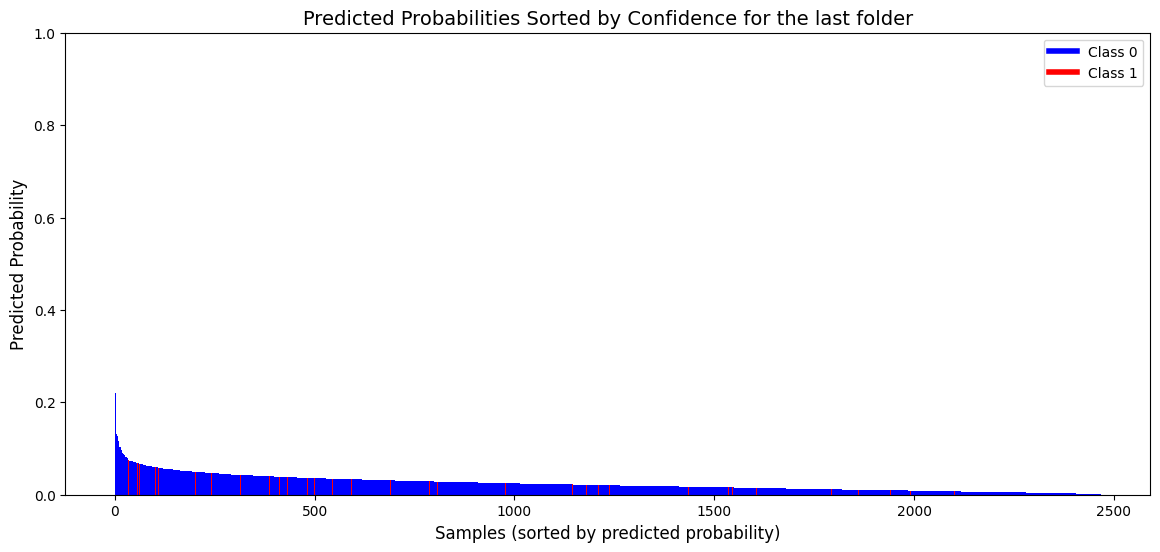

In [480]:
# Sort data by predicted probabilities
sorted_indices = np.argsort(y_test_proba)[::-1]  # Sort in descending order
sorted_probs = y_test_proba[sorted_indices]
sorted_labels = y_test[sorted_indices]

# Define colors based on labels
colors = ['blue' if label == 0 else 'red' for label in sorted_labels]

# Plot
plt.figure(figsize=(14, 6))
plt.bar(range(len(y_test)), sorted_probs, color=colors, width=1)

# Labels and aesthetics
plt.xlabel("Samples (sorted by predicted probability)", fontsize=12)
plt.ylabel("Predicted Probability", fontsize=12)
plt.title("Predicted Probabilities Sorted by Confidence for the last folder", fontsize=14)
plt.ylim(0, 1)

# Custom legend
plt.legend(handles=[
    plt.Line2D([0], [0], color='blue', lw=4, label='Class 0'),
    plt.Line2D([0], [0], color='red', lw=4, label='Class 1')
], loc="upper right")

plt.show()

# Random Tries with Feature-Based Classifier
## not important

In [469]:
# from sklearn.metrics import pairwise_distances
# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(strategy='mean')
# X_train_imp = imp.fit_transform(X_train)
# X_test_imp = imp.transform(X_test)

# X_test_pos = X_train_imp[y_train==1]

# test_pos_indices = np.where(y_train==1)[0]

# r = []
# for feat in range(X_train_imp.shape[1]):
#     s = pairwise_distances(X_test_pos[:, feat].reshape(-1,1), X_train_imp[:, feat].reshape(-1,1))
#     closest_indices = np.argsort(s, axis=1)
#     first_time_correct = (y_train[closest_indices[:,1:]].cumsum(axis=1)!=1).argmin(axis=1)
#     cur_pd = pd.DataFrame({'sample':test_pos_indices, "correct":first_time_correct})
#     cur_pd['feat'] = feat
#     r.append(cur_pd)
# r = pd.concat(r)
# r.reset_index(drop=True, inplace=True)
# r


In [470]:
# df_min = r.iloc[r.groupby('sample')['correct'].idxmin()]
# df_min

In [471]:
# df_min[['feat', 'correct']].value_counts()

In [472]:
# vc = df_min[['feat', 'correct']].value_counts()
# unq_feats = vc.iloc[:((vc.cumsum()/y_train.sum()) > 0.8).argmax()].reset_index()['feat'].unique()
# max_range = vc.iloc[:((vc.cumsum()/y_train.sum()) > 0.8).argmax()].reset_index()['correct'].max() + 1
# max_range

In [473]:
# from sklearn.base import BaseEstimator
# from sklearn.neighbors import NearestNeighbors

# class FeatRadius(BaseEstimator):
    
#     def __init__(self, cumsum_threshold = 0.8):
#         self.cumsum_threshold=cumsum_threshold
        
#     def fit(self, X, y):
#         test_pos_indices = np.where(y == 1)[0]
#         self.X_train = X
#         self.y_train = y
        
#         r = []
        
#         for feat in range(X.shape[1]):
#             s = pairwise_distances(X[test_pos_indices, feat].reshape(-1,1), X[:, feat].reshape(-1,1))
#             closest_indices = np.argsort(s, axis=1)
#             first_time_correct = (y[closest_indices[:,1:]].cumsum(axis=1)!=1).argmin(axis=1)
#             cur_pd = pd.DataFrame({'sample':test_pos_indices, "correct":first_time_correct})
#             cur_pd['feat'] = feat
#             r.append(cur_pd)
#         r = pd.concat(r)
#         r.reset_index(drop=True, inplace=True)
#         self.r = r
#         df_min = r.iloc[r.groupby('sample')['correct'].idxmin()]
#         vc = df_min[['feat', 'correct']].value_counts()
#         self.unq_feats = vc.iloc[:((vc.cumsum()/y_train.sum()) > self.cumsum_threshold).argmax()].reset_index()['feat'].unique()
#         self.max_range = vc.iloc[:((vc.cumsum()/y_train.sum()) > self.cumsum_threshold).argmax()].reset_index()['correct'].max() + 1
#         self.knns = {}
#         for feat in self.unq_feats:
#             knn = NearestNeighbors(n_neighbors=self.max_range)
#             knn.fit(self.X_train[:,feat].reshape(-1,1))
#             self.knns[feat] = knn
        
#     def predict_proba(self, X):
#         pred = np.zeros(len(X))
#         for feat in self.unq_feats:
#             closest_indices = self.knns[feat].kneighbors(X[:,feat].reshape(-1,1), return_distance=False)
#             nn_labels = self.y_train[closest_indices[:,:self.max_range]]
#             pred += (nn_labels.sum(axis=1)>0).astype(bool)
#         pred /= len(self.unq_feats)
#         pred[pred>0] += 0.5
#         pred = np.hstack((1-pred.reshape(-1,1), pred.reshape(-1,1)))
#         return pred
    
#     def predict(self,X):
#         y_proba = self.predict_proba(X)
#         return (y_proba[:,1] > 0.5)
    
# cc = FeatRadius()
# cc.fit(X_train_imp, y_train)
# print('fitted')
# cc.predict_proba(X_test_imp)

<Axes: xlabel='feat,correct'>

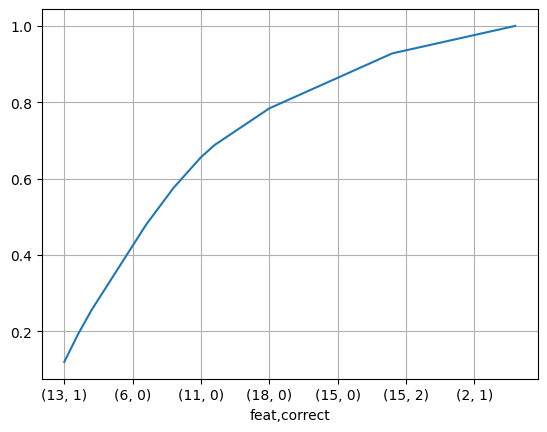

In [276]:
(vc.cumsum()/y_train.sum()).plot(grid='on')